In this notebook we compare the muTT and muRT for three spheres sedimenting in a triangle, perpendicular to the plane of the triangle

    - Superposition/Pystokes
    - 2s (2s - similar to FTS Stokesian dynamics, but without adhoc lubrication effects)
    - 2s, 3t (3t)
    - 2s, 3t, 3a (3a)
    - 2s, 3t, 3a, 3s (long-ranged)

Comparison to **Helen J Wilson (2013)** of three (freely rotating) spheres in a triangle, method based on Lamb's solution and method of reflections (MR) - convergence, so in principle exact. Good benchmark

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt

import pystokes
from solveFull import linearSolve_krylov as Full

In [2]:
PI = 3.14159265359

# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 3, 0.1

## passive particle
D0  = 0.      
S0  = 0.

## normalising factor: one-particle mobility
mu0 = 1./(6*PI*eta*b)

In [3]:
rHW = np.array([2.01, 2.05, 2.10, 2.15, 2.20, 2.25, 2.30, 2.40, 2.50, 2.60, 2.70, 2.80, 2.90, 3.00])

muTT_HW = np.array([1.79223228, 1.79070892, 1.77826951, 1.76311004, 1.74703222, 1.73072508, 1.71452988, 1.68314045, 1.65356957, 1.62599574, 1.60039150,
                    1.57664602, 1.55461831, 1.53416156])
muRT_HW = np.array([0.159607490, 0.195478184, 0.209731929, 0.214756269, 0.215412007, 0.213577673, 0.210224103, 0.201041187, 0.190411103, 0.179481457, 0.168801210,
                    0.158630515, 0.149081378, 0.140187608])

In [4]:
## Force = 6*pi*eta*b in HW

### Pystokes

In [5]:
pstk = pystokes.unbounded.Rbm(b, Np, eta)

muTT_pstk = np.zeros(rHW.shape[0])
muRT_pstk = np.zeros(rHW.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
 
## perpendicular
k=0
for rHW_ in rHW:
    # triangle
    # x components
    r[0] = -rHW_/2.
    r[1] =  rHW_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rHW_/6.
    r[1+2*Np] =  np.sqrt(3)*rHW_/6.
    r[2+2*Np] = -np.sqrt(3)*rHW_/3.
    
    for i in range(Np):
        #force perpendicular to triangle - along y axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    muTT_pstk[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[Np=3] is vy of particle one
    muRT_pstk[k] = np.abs(o[2]/mu0) ## due to symmetry, use angular velocity of particle 3, which is purely in x direction
    k += 1

In [6]:
muTT_pstk/muTT_HW

array([1.0430636 , 1.03187192, 1.02474085, 1.0199559 , 1.01642804,
       1.0137128 , 1.01156793, 1.00843513, 1.00630783, 1.00481127,
       1.00372991, 1.00293167, 1.00233187, 1.0018743 ])

In [7]:
muRT_pstk/muRT_HW

array([2.01454284, 1.58130583, 1.40449032, 1.30857651, 1.24596724,
       1.201437  , 1.16810992, 1.12179724, 1.09156501, 1.07066994,
       1.05564722, 1.04452561, 1.03610196, 1.0296029 ])

______________

## Full solver (2s, 3t, 3a, 3s)

In [8]:
full = Full(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

muTT_full = np.zeros(rHW.shape[0])
muRT_full = np.zeros(rHW.shape[0])

r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(9*Np)
D = np.zeros(3*Np)

## perpendicular
k=0
for rHW_ in rHW:
    # triangle
    # x components
    r[0] = -rHW_/2.
    r[1] =  rHW_/2.
    r[2] =  0.
    
    # z components
    r[0+2*Np] =  np.sqrt(3)*rHW_/6.
    r[1+2*Np] =  np.sqrt(3)*rHW_/6.
    r[2+2*Np] = -np.sqrt(3)*rHW_/3.
    
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 1.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    full.RBM(v, o, r, F, T, S, D)
        
    muTT_full[k] = v[0+Np]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility, v[Np=3] is vy of particle one
    muRT_full[k] = np.abs(o[2]/mu0) ## due to symmetry, use angular velocity of particle 3, which is purely in x direction
    k += 1

In [9]:
muTT_full/muTT_HW

array([1.01495337, 1.00757381, 1.00435008, 1.00278113, 1.00191087,
       1.00139592, 1.0010765 , 1.00072916, 1.00055463, 1.00044827,
       1.00037262, 1.00031348, 1.00026505, 1.0002246 ])

In [10]:
muRT_full/muRT_HW

array([1.46901447, 1.19151601, 1.09753086, 1.05546418, 1.0328268 ,
       1.01964305, 1.01163548, 1.00351847, 1.00029169, 0.9990621 ,
       0.99867709, 0.99864713, 0.99875729, 0.99891298])

________

### Plotting versus Helen Wilson

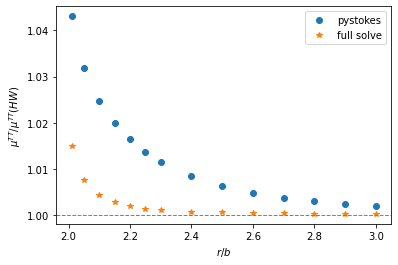

In [13]:
plt.plot(rHW, muTT_pstk/muTT_HW, label='pystokes', marker='o', linestyle="None")
plt.plot(rHW, muTT_full/muTT_HW, label='full solve', marker='*', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu^{TT}/\mu^{TT}(HW)$')
plt.legend()
plt.show()

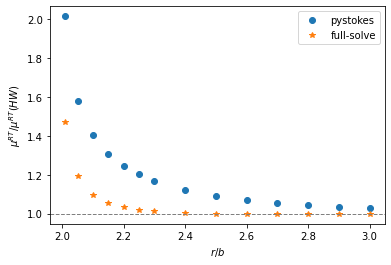

In [14]:
plt.plot(rHW, muRT_pstk/muRT_HW, label='pystokes', marker='o', linestyle="None")
plt.plot(rHW, muRT_full/muRT_HW, label='full-solve', marker='*', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu^{RT}/\mu^{RT}(HW)$')
plt.legend()
plt.show()